In [1]:
from ModelTransfuser.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch

import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [3]:
# Define the ModelTransfuser

# Time steps for the diffusion process
T = 50
t = torch.linspace(0, 1, T)

model = ModelTransfuser(T, train_data.shape)

model = model.load('ModelTransfuser/models/ModelTransfuser_cudaTest.pickle')

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
with open('ModelTransfuser/models/ModelTransfuser_cudaTest.pickle', 'rb') as f:
    model = pickle.load(f)

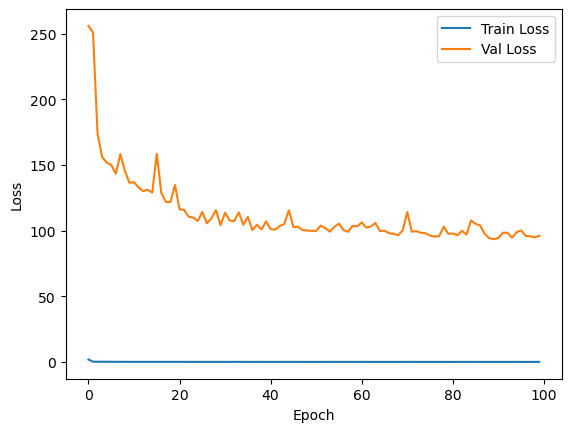

In [4]:
epoch = np.arange(0, len(model.train_loss))

plt.plot(epoch, np.array(model.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(model.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Data Generation

In [5]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [6]:
val_data[:1]

tensor([[-2.7104, -2.8187,  0.0938,  0.5076,  0.4899,  4.5705, -0.0844, -0.2125,
          0.2124, -0.0435, -0.0080,  0.2303,  0.0644,  0.0697]])

In [7]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [13]:
p = model.sample(val_data[1:2], condition_mask=mask, device='cuda:0').to('cpu')

100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


In [14]:
p.shape

torch.Size([1, 1000, 14])

In [15]:
print(p.mean(axis=1))
print(p.std(axis=1))
print(val_data[1:2])

tensor([[-2.2932, -2.8809, -0.2642,  0.5544,  0.5010,  7.4392,  0.1854,  0.1740,
         -0.1011,  0.3229,  0.0553,  0.6386,  0.4327,  0.2450]])
tensor([[0.0052, 0.0054, 0.0058, 0.0018, 0.0018, 0.0713, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[-2.0697, -2.7872, -0.3723,  0.4962,  0.4666,  7.0081,  0.1854,  0.1740,
         -0.1011,  0.3229,  0.0553,  0.6386,  0.4327,  0.2450]])


In [18]:
(val_data[1:2]-p.mean(axis=1))

tensor([[ 2.2347e-01,  9.3683e-02, -1.0808e-01, -5.8236e-02, -3.4346e-02,
         -4.3102e-01, -2.9802e-08,  0.0000e+00, -3.7253e-08, -5.9605e-08,
         -3.7253e-09, -1.1921e-07, -1.7881e-07, -5.9605e-08]])

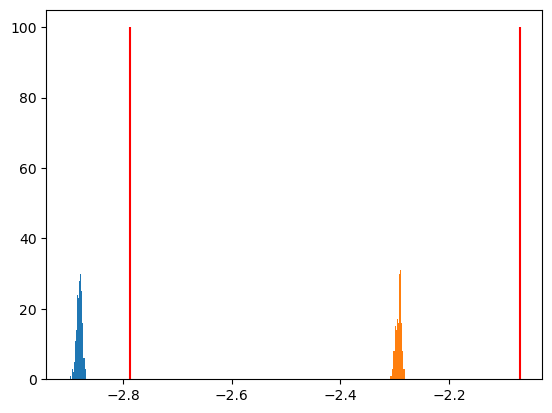

In [19]:
plt.hist(p[0,:,1], bins=100)
plt.hist(p[0,:,0], bins=100)
plt.vlines(val_data[1,1], 0, 100, color='red')
plt.vlines(val_data[1,0], 0, 100, color='red')
plt.show()

In [20]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [ ]:
p = model.sample(val_data[:1000], condition_mask=mask.repeat(1000,1), device="cuda:0").to("cpu")

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 282/1000 [01:10<02:59,  3.99it/s]

In [13]:
torch.mean(100*torch.abs((val_data[:1000]-p.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([  3.8102,   4.0290, 294.3724,  15.3292,  18.1108,  32.4858])